In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

## Dynamic Programming

### Q1: Implement the discrete MDP model.

<img src="RL_homework1.pdf.png">

In [3]:
P=np.zeros((3,3,3))
R=np.zeros((3,3))
P[0,0,0]=0.55
P[1,0,0]=0.45
R[0,0]=0
P[0,1,0]=0.3
P[1,1,0]=0.7
R[0,1]=0
P[0,2,0]=1
R[0,2]=5/100

P[0,0,1]=1
R[1,0]=0
P[1,1,1]=0.4
P[2,1,1]=0.6
R[1,1]=0
P[1,2,1]=1
R[1,2]=0

P[1,0,2]=1
R[2,0]=0
P[1,1,2]=0.6
P[2,1,2]=0.4
R[2,1]=1
P[2,2,2]=1
R[2,2]=0.9


P is the transition 3x3x3 matrix of the given MDP model, the first index indicates the next state, the second one indicates the
action taken and the third one is for the previous (or the current) state.


R is the reward 3x3 matrix, its rows represent the states and its columns the actions.

### Optimal policy

$\pi^{*}(s_0)=a_1$

$\pi^{*}(s_1)=a_1$

$\pi^{*}(s_2)=a_2$

### Q2:  Implement and run value iteration (VI) in order to identify a 0.01–optimal policy. 

In [4]:
def Value_iteration(P,R,discount_factor,precision):
    v_new=np.zeros((1,np.shape(P)[0])) # V in R^N where N number of states.
    v_old=np.zeros((1,np.shape(P)[0])) #to not trigger the stopping criterion from the beginning
    iteration=0 #Counter for the number of iterations before convergence
    while(abs(np.max(v_old-v_new))>precision or iteration<2): # stopping criterion (iteration<2 
        #because v_new_1=[0.05 0.   1.  ] and [0.0975 0.57   1.85  ] causing the algorithm to stop at the second iteration )
        v_old=v_new
        V=np.zeros((np.shape(P)[0],np.shape(P)[1]))
        #compute all T\pi V_k for all policies possible
        for x in range(np.shape(P)[0]):#asynchronous VI
            for a in range(np.shape(P)[1]):
                V[x,a]=R[x,a]+discount_factor*np.sum(P[:,a,x]*v_new)
        v_new=np.max(V,axis=1)#V_k+1= TV_k maximizing to get the value for the optimal policy
        iteration+=1 #increasing the counter
    p=np.argmax(V,axis=1) #optimal policy
    return np.array([p,v_new,iteration])

The function VI (value iteration) takes in argument the transition and reward matrices, The discount_factor (gamma) and the
precision of the optimal policy. It returns an array of three elements, the first one is the optimal policy, the second one the
optimal value and the third one is the number of iteration till the while condition is unsatisfied anymore.

In [5]:
print('The 0.01-optimal policy is : ', Value_iteration(P,R,0.95,0.01)[0], '\nThe 0.01-optimal value is:', Value_iteration
(P,R,0.95,0.01)[1])

The 0.01-optimal policy is :  [1 1 2] 
The 0.01-optimal value is: [15.2048944  16.36212427 17.81373717]


In [6]:
Value_iteration(P,R,0.95,0.01)

array([array([1, 1, 2], dtype=int64),
       array([15.2048944 , 16.36212427, 17.81373717]), 89], dtype=object)

### Plot $∥v_k − v^∗∥_∞$ as a function of iteration k, knowing that $d^∗ = [a_1, a_1, a_2]$ (i.e., implement policy evaluation).

In [7]:
pi_optimal=[1,1,2]
P_pi=np.array([P[:,int(pi_optimal[0]),0],P[:,int(pi_optimal[1]),1],P[:,int(pi_optimal[2]),2]])
r_pi=np.array([R[0,int(pi_optimal[0])],R[1,int(pi_optimal[1])],R[2,int(pi_optimal[2])]])
v_optimal=np.dot(np.linalg.inv(np.eye(np.shape(P)[0])-0.95*P_pi),r_pi)

Calculating the optimal value given the optimal policy, using the exact formula (matrix formula: $V^{\pi} =(I_n−\gamma P^{\pi})^{−1}r^{\pi}$).

In [8]:
def policy_evaluation(k,P,R,discount_factor,v_optimal):
    v_new=np.zeros((1,np.shape(P)[0]))
    for i in range(k):
        V=np.zeros((np.shape(P)[0],np.shape(P)[1]))
        for x in range(np.shape(P)[0]):
            for a in range(np.shape(P)[1]):
                V[x,a]=R[x,a]+discount_factor*np.sum(P[:,a,x]*v_new)
        v_new=np.max(V,axis=1)
    return abs(np.max(v_optimal-v_new))

The function policy_evaluation takes in argument The number of iterations k, the transition and reward matrices, The
discount_factor (gamma) and the the optimal value. It returns the maximum difference elementwise between the
optimal value and the estimated one.

In [9]:
k=[i for i in range(300)]
value_convergence=[policy_evaluation(i,P,R,0.95,v_optimal) for i in range(300)]

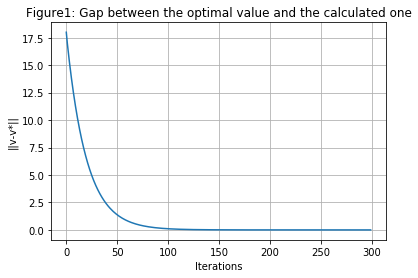

In [10]:
plt.plot(k,value_convergence)
plt.xlabel('Iterations')
plt.ylabel('||v-v*||')
plt.grid()
plt.title('Figure1: Gap between the optimal value and the calculated one')
plt.show()

The figure tells us that the gap between the optimal value and the calculated one decreases when the number of iteration
increases till it converges to 0 around 110 iterations which is just the contraction property of the bellman operator $∥v_{k+1} − v^∗∥_∞<\gamma ∥v_{k} − v^∗∥_∞$

### Q3: implement policy iteration (PI) with initial policy $\pi_0=[a_0,a_1,a_2]$

In [11]:
def Policy_iteration(P,R,discount_factor):
    p=[1,1,2]
    v_old=np.zeros(len(P))
    is_changed=True
    iteration=0
    while(is_changed):
        P_pi=np.array([P[:,int(p[0]),0],P[:,int(p[1]),1],P[:,int(p[2]),2]])
        r_pi=np.array([R[0,int(p[0])],R[1,int(p[1])],R[2,int(p[2])]])
        v_pi_new=np.dot(np.linalg.inv(np.eye(np.shape(P)[0])-discount_factor*P_pi),r_pi)
        if((v_pi_new==v_old).all()):
            is_changed=False
        v_old=v_pi_new
        V=np.zeros((np.shape(P)[0],np.shape(P)[1]))
        for x in range(np.shape(P)[0]):
            for a in range(np.shape(P)[1]):
                V[x,a]=R[x,a]+discount_factor*np.sum(P[:,a,x]*v_pi_new)
        p=np.argmax(V,axis=1)
        iteration+=1
    return [p,v_pi_new,iteration]

The function Policy_iteration takes in argument the number of iterations k, the transition and reward matrices, the discount_factor (gamma).

It returns an array of three elements, the first one is the optimal policy, the second one the optimal
value and the third one is the number of iterations till the while condition is unsatisfied anymore.

For the policy evaluation
step I used the direct computation method, since the given MDP is not too complex (matrix formula: $V^{\pi} =(I_n−\gamma P^{\pi})^{−1}r^{\pi}$).

In [12]:
t=time.time()
value_iteration=Value_iteration(P,R,0.95,0)
elapsed=time.time()-t

In [13]:
t=time.time()
policy_iteration=Policy_iteration(P,R,0.95)
elapsed_2=time.time()-t

In [14]:
print('The time taken by the value iteration algorithm to converge is', elapsed)
print('The number of value iterations till convergence is: ', value_iteration[2])
print('The time taken by the policy iteration algorithm to converge is', elapsed_2)
print('The number of policy iterations till convergence is: ', policy_iteration[2])

The time taken by the value iteration algorithm to converge is 0.05883979797363281
The number of value iterations till convergence is:  647
The time taken by the policy iteration algorithm to converge is 0.0012776851654052734
The number of policy iterations till convergence is:  2


<div class="alert alert-block alert-success">
The time taken to converge, in this case, of the VI approach is larger than the one taken by PI approach, but this is because
the VI is an approximatly method and then if we are searching for exact convergences we should wait a lot of iterations
unlike the PI approach which use the closed form of policy evaluation and then will converge rapidly, but if the dimension of
the problem is higher (the number of action and states is very large) then the computation of the policy evaluation using the
closed form will be computationnaly very expensive and then the PI will take much more time than the VI approach.
<p></p>
<p><b>
    The relative merits of the approches:</b></p>
<p>
-The pros of VI are: There isn't a lot of computation in each iteration (computationnally efficient).</p>

-The cons of VI are: The convergence is asymptotic and then the algorithm may need a lot of iterations to give a good
approximation of the optimal value.

-The pros of PI are: The PI approach converges to the exact optimal value unlike the VI approach in a finite number of
iterations (generally not very large).

-The cons of PI are: The PI approach is computationnally expensive since it needs to do at each iteration a complete policy
evaluation which need a lot of calculation, specially when the matrix closed form is used.
</div>

## Reinforcement Learning

### A review of RL Agent/ Environment Interaction

### Q4: Build an estimator of $V_n$ and plot $J_n − J_{\pi}$ as a function of n

[[0, 0], [0, 1], [0, 2], [0, 3], [1, 0], [1, 2], [1, 3], [2, 0], [2, 1], [2, 2], [2, 3]]
[[ 0  1  2  3]
 [ 4 -1  5  6]
 [ 7  8  9 10]]
[[0, 1], [0, 2], [0, 1, 2], [0], [1, 3], [0, 1, 3], [0], [0, 3], [0, 2], [0, 2, 3], [2, 3]]
s0: ['right' 'down']
s1: ['right' 'left']
s2: ['right' 'down' 'left']
s3: ['right']
s4: ['down' 'up']
s5: ['right' 'down' 'up']
s6: ['right']
s7: ['right' 'up']
s8: ['right' 'left']
s9: ['right' 'left' 'up']
s10: ['left' 'up']


C:\Users\dell\Anaconda\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide


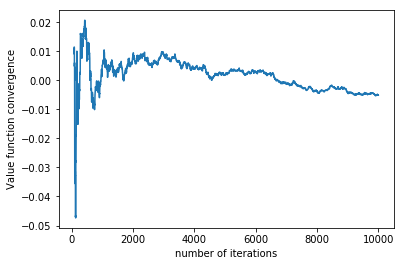

In [15]:
from gridworld import GridWorld1
import gridrender as gui
import numpy as np
import time
import matplotlib.pyplot as plt

env = GridWorld1

################################################################################
# investigate the structure of the environment
# - env.n_states: the number of states
# - env.state2coord: converts state number to coordinates (row, col)
# - env.coord2state: converts coordinates (row, col) into state number
# - env.action_names: converts action number [0,3] into a named action
# - env.state_actions: for each state stores the action availables
#   For example
#       print(env.state_actions[4]) -> [1,3]
#       print(env.action_names[env.state_actions[4]]) -> ['down' 'up']
# - env.gamma: discount factor
################################################################################
print(env.state2coord)
print(env.coord2state)
print(env.state_actions)
for i, el in enumerate(env.state_actions):
        print("s{}: {}".format(i, env.action_names[el]))

################################################################################
# Policy definition
# If you want to represent deterministic action you can just use the number of
# the action. Recall that in the terminal states only action 0 (right) is
# defined.
# In this case, you can use gui.renderpol to visualize the policy
################################################################################
pol = [1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 3]
#gui.render_policy(env, pol)

################################################################################
# Try to simulate a trajectory
# you can use env.step(s,a, render=True) to visualize the transition
################################################################################

#env.render = True
state = 0
fps = 1
for i in range(5):
        action = np.random.choice(env.state_actions[state])
        nexts, reward, term = env.step(state,action)
        state = nexts
        time.sleep(1./fps)

################################################################################
# You can also visualize the q-function using render_q
################################################################################
# first get the maximum number of actions available
max_act = max(map(len, env.state_actions))
q = np.random.rand(env.n_states, max_act)
#gui.render_q(env, q)

################################################################################
# Work to do: Q4
################################################################################
# here the v-function and q-function to be used for question 4
n = 10000
policy = np.zeros(11)
policy[4], policy[10] = 3,3
l = [env.reset() for i in range(n)]
unique, counts = np.unique(l, return_counts=True)
mu0 = counts/np.sum(counts)         # mu0 , starting state distribution
l = np.zeros(11)
N = np.zeros(11)
J_n = np.zeros(n)
for i in range(n):
#    state = np.random.randint(11)
    state = env.reset()
    state_i = state
    N[state_i] += 1
    cpt=0
    while(state not in [3,6] and cpt<1/(1-env.gamma)):
        nexts, reward, term = env.step(state,policy[state])
        state = nexts
        cpt+=1
    l[state_i] += reward*np.power(env.gamma,cpt-1)
    V = l/N
    J_n[i] = np.dot(mu0,V)


        
v_q4 = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.67106071, -0.99447514, 0.00000000, -0.82847001, -0.87691855,
        -0.93358351, -0.99447514]
J_pi = np.dot(mu0,v_q4)
plt.figure()
plt.xlabel('number of iterations')
plt.ylabel("Value function convergence")
plt.plot(J_n-J_pi)


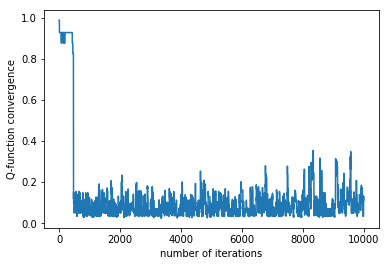

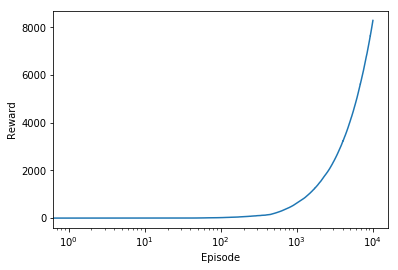

In [16]:
##Q5:
# Q-learning Algorithm
v_opt = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.82369294, 0.92820033, 0.00000000, 0.77818504, 0.82369294,
         0.87691855, 0.82847001]

eps = 3e-2
Q = -1e8*np.ones((11,4))
for s in range(11):
    for a in env.state_actions[s]:
        Q[s][a] = 0
diff = []
list_reward = np.zeros(n)
for i in range(n):
#    state = np.random.randint(11)
    state = env.reset()
    cpt = 0
    count = np.zeros((11,4))
    while (state not in [3,6] and cpt<1/(1-env.gamma)):
        action = np.argmax(Q[state]) if (np.random.rand()<1-eps) else np.random.choice(env.state_actions[state])
        count[state,action]+=1
        nexts, reward, term = env.step(state,action)
        Q[state,action] = (1-1/count[state,action])*Q[state,action] + (1/count[state,action])*(reward + env.gamma * np.amax(Q[nexts]))
        state = nexts
        list_reward[i]+=reward
        cpt+=1   
    pi_opt  = np.argmax(Q,axis=1)
    v_exp = [Q[state,pi_opt[state]] for state in range(11)]
    diff += [np.amax(np.abs(np.subtract(v_exp,v_opt)))]

plt.figure()
plt.xlabel('number of iterations')
plt.ylabel("Q-function convergence")
plt.plot(diff)     
plt.figure()
plt.xlabel('Episode')
plt.ylabel("Reward")
plt.plot(np.cumsum(list_reward))
plt.xscale("log")



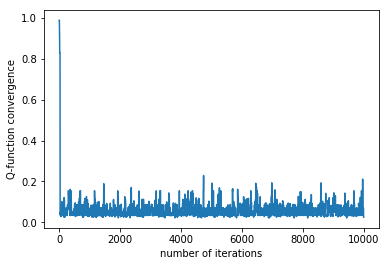

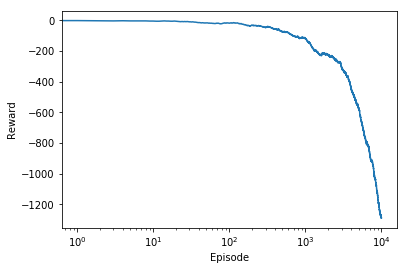

In [19]:
##Q5:
# Q-learning Algorithm
v_opt = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.82369294, 0.92820033, 0.00000000, 0.77818504, 0.82369294,
         0.87691855, 0.82847001]

eps = 1
Q = -1e8*np.ones((11,4))
for s in range(11):
    for a in env.state_actions[s]:
        Q[s][a] = 0
diff = []
list_reward = np.zeros(n)
for i in range(n):
#    state = np.random.randint(11)
    state = env.reset()
    cpt = 0
    count = np.zeros((11,4))
    while (state not in [3,6] and cpt<1/(1-env.gamma)):
        action = np.argmax(Q[state]) if (np.random.rand()<1-eps) else np.random.choice(env.state_actions[state])
        count[state,action]+=1
        nexts, reward, term = env.step(state,action)
        Q[state,action] = (1-1/count[state,action])*Q[state,action] + (1/count[state,action])*(reward + env.gamma * np.amax(Q[nexts]))
        state = nexts
        list_reward[i]+=reward
        cpt+=1   
    pi_opt  = np.argmax(Q,axis=1)
    v_exp = [Q[state,pi_opt[state]] for state in range(11)]
    diff += [np.amax(np.abs(np.subtract(v_exp,v_opt)))]

plt.figure()
plt.xlabel('number of iterations')
plt.ylabel("Q-function convergence")
plt.plot(diff)     
plt.figure()
plt.xlabel('Episode')
plt.ylabel("Reward")
plt.plot(np.cumsum(list_reward))
plt.xscale("log")



<div class="alert alert-block alert-success">
The Robbins-Monro conditions implie a choice of a learning rate $\alpha_{i} = \frac{1}{i}$.
For $\epsilon$, we could affirm that the value of ε represent the trade-off between the maximum reward and
the convergence to the optimal value, by choosing ε very small, we don't allow for much exploration then the convergence to
the optimal value will be very slowly w.r.t to the number of iterations but the accumulated reward will be significant . If ε is very large then we allow for a lot of exploration, the convergence to the optimal value will come
rapidly but the accumulated reward will be very small or negative.
We could choose $\epsilon=0.03$
</div>


<div class="alert alert-block alert-success">
<b>Q6:</b>
Because the graph of the states (grid) is irreductible (i.e for any two different states, there exists a path from one to the other) and the loop of trajectory will reach all the states when the number of iteration is sufficiently large. 
And thus, so changing the initial distribution cannot possibly change the policy to which we converge.

<p></p>
In the other case where the graph is reductible, if we use a distribution that gives a poor probability (or null in the extreme case) to the nodes of a related componant (composante connexe) then those states will never be reached by the other states of other related componant and this may affect the optimal policy.
</div>